Comprobación: 0.908%


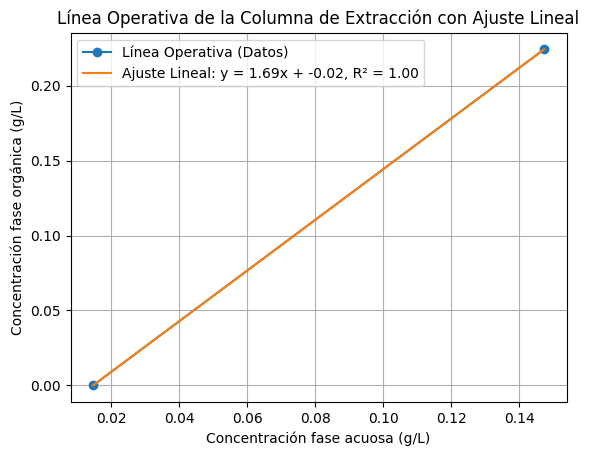

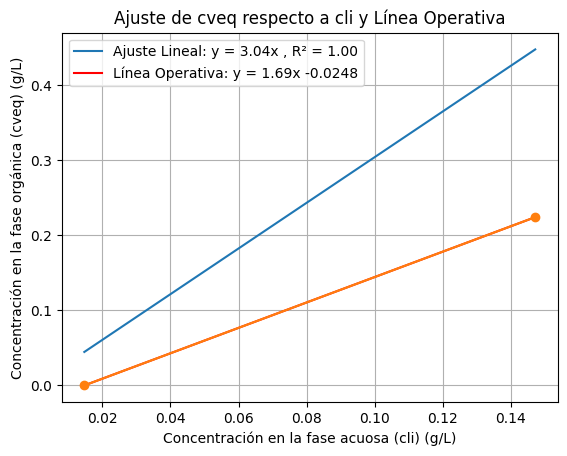

,Intervalo,cvic,cli,cveq,div,intgr
0,0,0.000000,0.014667,0.044587,22.428230,0.000003
1,100,0.022436,0.027935,0.084924,16.003159,0.000004
2,200,0.044872,0.041204,0.125261,12.439565,0.000005
3,300,0.067309,0.054473,0.165598,10.174010,0.000006
4,400,0.089745,0.067742,0.205936,8.606544,0.000007
5,500,0.112181,0.081011,0.246273,7.457586,0.000008
6,600,0.134617,0.094280,0.286610,6.579266,0.000009
7,700,0.157054,0.107548,0.326947,5.886035,0.000010
8,800,0.179490,0.120817,0.367284,5.324966,0.000011
9,900,0.201926,0.134086,0.407622,4.861552,0.000012


,Parámetro,Valor
0,Fase acuosa (g/L),9.00
1,Fase orgánica (g/L),23.20
2,kd,3.04


,Absorbancia,Valor
0,Refinado,0.132
1,Extracto,0.520
2,Alimentación,1.325


,Concentración,Valor
0,Alimentación (g/L),0.147222
1,Refinado (g/L),0.014667
2,Extracto (g/L),0.224138


,Parámetro,Valor
0,Diámetro (m),0.055000
1,Área (m^2),0.002376
2,Altura (m),1.000000
3,Número de segmentos,1000.000000


,Parámetro,Valor
0,Tiempo refinado (h),0.002944
1,Tiempo extracto (h),0.005000
2,Volumen refinado (m^3),0.000013
3,Volumen extracto (m^3),0.000012
4,Caudal refinado (m³/h),0.001226
5,Caudal extracto (m³/h),0.000639


,kla,s$^{-1}$,h$^-1$
0,fase acuosa,0.000006,0.023279
1,fase organica,0.000003,0.012127


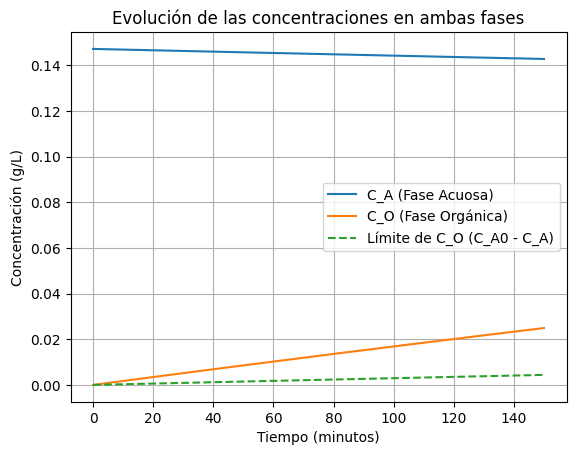

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from IPython.display import display
from scipy.integrate import odeint

D = 0.055  # diámetro de la columna (m)
A = np.pi * D**2 / 4  # Área interfacial (m^2)
H = 1  # Altura de la columna (m)
N = 1000  # Número de segmentos en los que se divide la columna para el cálculo

# Rectas de calibración
Fase_acuosa = 0.009 * 1000  # g/L ácido salicílico 
Fase_organica = 0.0232 * 1000  # g/L ácido salicílico
kd = 3.04  # dato proporcionado

# Datos experimentales
absorbancia_Refinado = 0.132
absorbancia_extracto = 0.52
absorbancia_alimentacion = 1.325
Tiempo_refinado = 10.6/3600   # s a h 
Tiempo_extracto = 18/3600   # s a h
Volumen_refinado = (13 / 1000000)# ml a m^3
Volumen_extracto = (11.5 / 1000000)  # ml a m^3
Q_refinado = (Volumen_refinado / Tiempo_refinado) / 3.6  # m³/h
Q_extracto = (Volumen_extracto / Tiempo_extracto) / 3.6  # m³/h


# Concentraciones mediante las curvas de calibrado
alimentacion = absorbancia_alimentacion / Fase_acuosa
disolvente = 1000-Fase_acuosa  # g/L
Refinado = absorbancia_Refinado / Fase_acuosa
Extracto = (absorbancia_extracto / Fase_organica) * 10

# Comprobacion disolución diluida g_soluto/g_disolvente que será sobre 1L 
comprobacion_d_diluida = (Fase_acuosa / disolvente) * 100  # en %
print(f"Comprobación: {comprobacion_d_diluida:.3f}%")

# Línea operativa: (C. alimentación, C. extracto), (C refinado, 0)
cvacuosa = [alimentacion, Refinado] 
clorg = [Extracto, 0]    
# Ajuste polinómico de grado 1 (recta)
coeficientes = np.polyfit(cvacuosa, clorg, 1)  # Ajuste lineal
polinomio = np.poly1d(coeficientes)  # Genera la función polinómica

# Predicciones basadas en el ajuste
clorg_ajuste = polinomio(cvacuosa)

# Cálculo de R^2
ss_res = np.sum((clorg - clorg_ajuste)**2)  # Suma de los cuadrados de los residuos
ss_tot = np.sum((clorg - np.mean(clorg))**2)  # Suma total de los cuadrados
r2 = 1 - (ss_res / ss_tot)  # Coeficiente de determinación (R^2)

# Gráfico de la línea operativa
# Extraer coeficientes
m, b = coeficientes  # Pendiente y ordenada al origen

# Crear la cadena de la ecuación
equation_str = f'Ecuación: y = {m:.4f}x + {b:.4f}'

# Añadir la ecuación a la leyenda
plt.plot(cvacuosa, clorg, marker='o', label='Línea Operativa (Datos)')
plt.plot(cvacuosa, clorg_ajuste, label=f'Ajuste Lineal: y = {coeficientes[0]:.2f}x + {coeficientes[1]:.2f}, R² = {r2:.2f}')
plt.xlabel('Concentración fase acuosa (g/L)')
plt.ylabel('Concentración fase orgánica (g/L)')
plt.title('Línea Operativa de la Columna de Extracción con Ajuste Lineal')
plt.legend()
plt.grid(True)
plt.show()

# Cálculo de la integral
result_integral = 0
cvic = np.zeros(N)  # FASE ORGANICA
cli = np.zeros(N)   # Inicializar array para cli
div = np.zeros(N)   # Inicializar array para div
cveq = np.zeros(N)   # Inicializar array para div
intgr = np.zeros(N-1)  # Inicializar array para intgr (ya que hay N-1 integrales)
for i in range(N):
    cvic[i] = i * (Extracto / (N-1))  # Calcular cvic
    if i == 0:
        cli[i] = Refinado  # Primer valor de cli
    else:
        cli[i] = (cvic[i] - b) / m  # Para i != 0
    cveq[i] = kd * cli[i]  # Línea de equilibrio 
    div[i] = 1 / (cveq[i] - cvic[i])  # Columna de división de la integral

# Realizamos la integración con la fórmula corregida
for i in range(N - 1):
    intgr[i] = (cvic[i+1] - cvic[i]) / (2 * (div[i] + div[i + 1]))
    result_integral += intgr
# Ajuste polinómico entre cli y cveq
coef_ajuste = np.polyfit(cli, cveq, 1)  # Ajuste lineal
polinomio_ajuste = np.poly1d(coef_ajuste)  # Genera la función polinómica

# Predicciones basadas en el ajuste
cveq_ajuste = polinomio_ajuste(cli)

# Cálculo de R^2 para el ajuste
ss_res_ajuste = np.sum((cveq - cveq_ajuste) ** 2)  # Suma de los cuadrados de los residuos
ss_tot_ajuste = np.sum((cveq - np.mean(cveq)) ** 2)  # Suma total de los cuadrados
r2_ajuste = 1 - (ss_res_ajuste / ss_tot_ajuste)  # Coeficiente de determinación (R^2)
# Gráfico del ajuste respecto a la línea operativa
plt.figure()
plt.plot(cli, cveq_ajuste, label=f'Ajuste Lineal: y = {coef_ajuste[0]:.2f}x , R² = {r2_ajuste:.2f}')
plt.plot(cvacuosa, clorg_ajuste, label=f'Línea Operativa: y = {coeficientes[0]:.2f}x {coeficientes[1]:.4f}', color='r')
plt.plot(cvacuosa, clorg, marker='o')
plt.xlabel('Concentración en la fase acuosa (cli) (g/L)')
plt.ylabel('Concentración en la fase orgánica (cveq) (g/L)')
plt.title('Ajuste de cveq respecto a cli y Línea Operativa')
plt.legend()
plt.grid(True)
plt.show()

# Cálculo de KLa
Kla = (Q_refinado / (A * H)) * result_integral[-1]  # en s^-1
Kla_acuosa = (Q_extracto / (A * H)) * result_integral[-1]  # en s^-1
klah = ((Q_refinado*3600) / (A * H)) * result_integral[-1]  # en s^-1
Kla_acuosah = ((3600*Q_extracto) / (A * H)) * result_integral[-1]  # en s^-1

# Tabla 1: Parámetros de la columna
tabla_columna = pd.DataFrame({
    'Parámetro': ['Diámetro (m)', 'Área (m^2)', 'Altura (m)', 'Número de segmentos'],
    'Valor': [D, A, H, N]
})

# Tabla 2: Rectas de calibración
tabla_calibracion = pd.DataFrame({
    'Parámetro': ['Fase acuosa (g/L)', 'Fase orgánica (g/L)', 'kd'],
    'Valor': [Fase_acuosa, Fase_organica, kd]
})

# Tabla 3: Absorbancias
tabla_absorbancias = pd.DataFrame({
    'Absorbancia': ['Refinado', 'Extracto', 'Alimentación'],
    'Valor': [absorbancia_Refinado, absorbancia_extracto, absorbancia_alimentacion]
})

# Tabla 4: Tiempos, volúmenes y caudales
tabla_tiempos_volumenes = pd.DataFrame({
    'Parámetro': ['Tiempo refinado (h)', 'Tiempo extracto (h)', 'Volumen refinado (m^3)', 'Volumen extracto (m^3)', 'Caudal refinado (m³/h)', 'Caudal extracto (m³/h)'],
    'Valor': [Tiempo_refinado, Tiempo_extracto, Volumen_refinado, Volumen_extracto, Q_refinado, Q_extracto]
})

# Tabla 5: Concentraciones
tabla_concentraciones = pd.DataFrame({
    'Concentración': ['Alimentación (g/L)',  'Refinado (g/L)', 'Extracto (g/L)'],
    'Valor': [alimentacion, Refinado, Extracto]
})
tabla_kla = pd.DataFrame({
    'kla' :['fase acuosa','fase organica'],
    's$^{-1}$':[Kla,Kla_acuosa],
    'h$^-1$':[klah,Kla_acuosah]
})
numero_del_intervalo = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]

# Crear la tabla con los valores seleccionados
tabla_resultados = pd.DataFrame({
    'Intervalo': numero_del_intervalo,
    'cvic': [cvic[i] for i in numero_del_intervalo],
    'cli': [cli[i] for i in numero_del_intervalo],
    'cveq': [cveq[i] for i in numero_del_intervalo],
    'div': [div[i] for i in numero_del_intervalo],
    'intgr': [intgr[i] if i < N-1 else np.nan for i in numero_del_intervalo]  # Último índice no tiene integral
})

# Mostrar la tabla
display(tabla_resultados)
display(tabla_calibracion)
display(tabla_absorbancias)
display(tabla_concentraciones)
display(tabla_columna)
display(tabla_tiempos_volumenes)
display(tabla_kla)


## cosas pendientes representar linea de equilibrio en la linea operativa junto a la ecuacion y r² 
## representar la variacion de concentracion respecto al tiempo
## representar el triangular 
# Parámetros de entrada
C_A0 = alimentacion  # Concentración inicial en la fase acuosa (g/L)
C_O0 = 0.0          # Concentración inicial en la fase orgánica (g/L)
kd = 3.04            # Coeficiente de distribución

# Coeficientes de transferencia de masa (en min^-1)
kLa_acuosa = Kla_acuosa * 60  # Convertido a minutos
kLa_organica = Kla * 60        # Convertido a minutos (asumiendo que ya tienes Kla para la fase orgánica)

# Tiempo de simulación (en minutos)
t = np.linspace(0, 150, 100)  # Tiempo de 0 a 140 minutos

# Definir el sistema de ecuaciones diferenciales
def modelo(y, t, kLa_acuosa, kLa_organica, kd):
    C_A, C_O = y  # Variables dependientes: concentración en fase acuosa y orgánica
    C_O_eq = C_A * kd  # Concentración de equilibrio en la fase orgánica

    # Ecuaciones diferenciales
    dC_A_dt = -kLa_acuosa * C_A  # La fase acuosa pierde soluto  aunque para ser exacto deberia ir multiplicado kla*caudal
    dC_O_dt = kLa_organica * (C_O_eq - C_O)  # aunque para ser exacto deberia ir multiplicado kla*caudal

    # Evitar que las concentraciones se vuelvan negativas
    dC_A_dt = max(dC_A_dt, -C_A)  # No permitir que C_A se vuelva negativo
    dC_O_dt = max(dC_O_dt, 0)  # Asegurarse de que C_O no sea negativo

    # Limitar la concentración de la fase orgánica
    dC_O_dt = min(dC_O_dt, C_A0 - C_O)  # No permitir que C_O supere C_A0

    return [dC_A_dt, dC_O_dt]

# Resolver la ecuación diferencial
y0 = [C_A0, C_O0]  # Condiciones iniciales [C_A(t=0), C_O(t=0)]

# Integramos las ecuaciones diferenciales
solucion = odeint(modelo, y0, t, args=(kLa_acuosa, kLa_organica, kd))

# Extraer los resultados
C_A = solucion[:, 0]  # Concentraciones fase acuosa
C_O = solucion[:, 1]  # Concentraciones fase orgánica

# Graficar los resultados
plt.figure()
plt.plot(t, C_A, label='C_A (Fase Acuosa)')
plt.plot(t, C_O, label='C_O (Fase Orgánica)')

# Graficar la línea límite de la fase orgánica
C_O_limite = C_A0 - C_A  # Límite máximo de C_O
plt.plot(t, C_O_limite, label='Límite de C_O (C_A0 - C_A)', linestyle='--')

plt.xlabel('Tiempo (minutos)')
plt.ylabel('Concentración (g/L)')
plt.title('Evolución de las concentraciones en ambas fases')
plt.legend()
plt.grid(True)
plt.show()